In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import itertools
from scipy.stats import mannwhitneyu


In [52]:
df = pd.read_csv("Sleep_Efficiency.csv")
df['Sleep total quality'] = df['Sleep duration']*df['Sleep efficiency']
df.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency,Sleep total quality
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0,5.28
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0,4.62
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0,7.12
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0,3.06
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0,6.08


In [53]:
df = df.dropna(subset=['Caffeine consumption'])

caffeine_users = df[df['Caffeine consumption'] > 0]
non_caffeine_users = df[df['Caffeine consumption'] == 0]

summary = pd.DataFrame({
    "Group": ["Caffeine Users", "Non-Caffeine Users"],
    "Mean": [
        caffeine_users["Sleep total quality"].mean(),
        non_caffeine_users["Sleep total quality"].mean()
    ],
    "Std": [
        caffeine_users["Sleep total quality"].std(),
        non_caffeine_users["Sleep total quality"].std()
    ],
    "Count": [
        caffeine_users["Sleep total quality"].count(),
        non_caffeine_users["Sleep total quality"].count()
    ]
})

print(summary)


                Group      Mean       Std  Count
0      Caffeine Users  5.948565  1.207666    216
1  Non-Caffeine Users  5.839076  1.194978    211


##  feature selection - correlation matrix:

In [54]:
numeric_df = df.select_dtypes(include='number')
variables = numeric_df.columns
pvals = pd.DataFrame(np.ones((len(variables), len(variables))), columns=variables, index=variables)

for i in variables:
    for j in variables:
        if i != j:
            valid_rows = numeric_df[[i, j]].dropna()
            if len(valid_rows) > 1:  # Need at least 2 points
                corr_test = pearsonr(valid_rows[i], valid_rows[j])
                pvals.loc[i, j] = corr_test[1]


pvals_flat = pvals.where(np.triu(np.ones(pvals.shape), k=1).astype(bool)).stack().values
_, pvals_corrected, _, _ = multipletests(pvals_flat, method='bonferroni')

pvals_corrected_matrix = pvals.copy()
pvals_corrected_matrix[:] = np.nan
pvals_corrected_matrix.values[np.triu_indices_from(pvals_corrected_matrix, k=1)] = pvals_corrected
pvals_corrected_matrix = pvals_corrected_matrix.fillna(pvals_corrected_matrix.T)


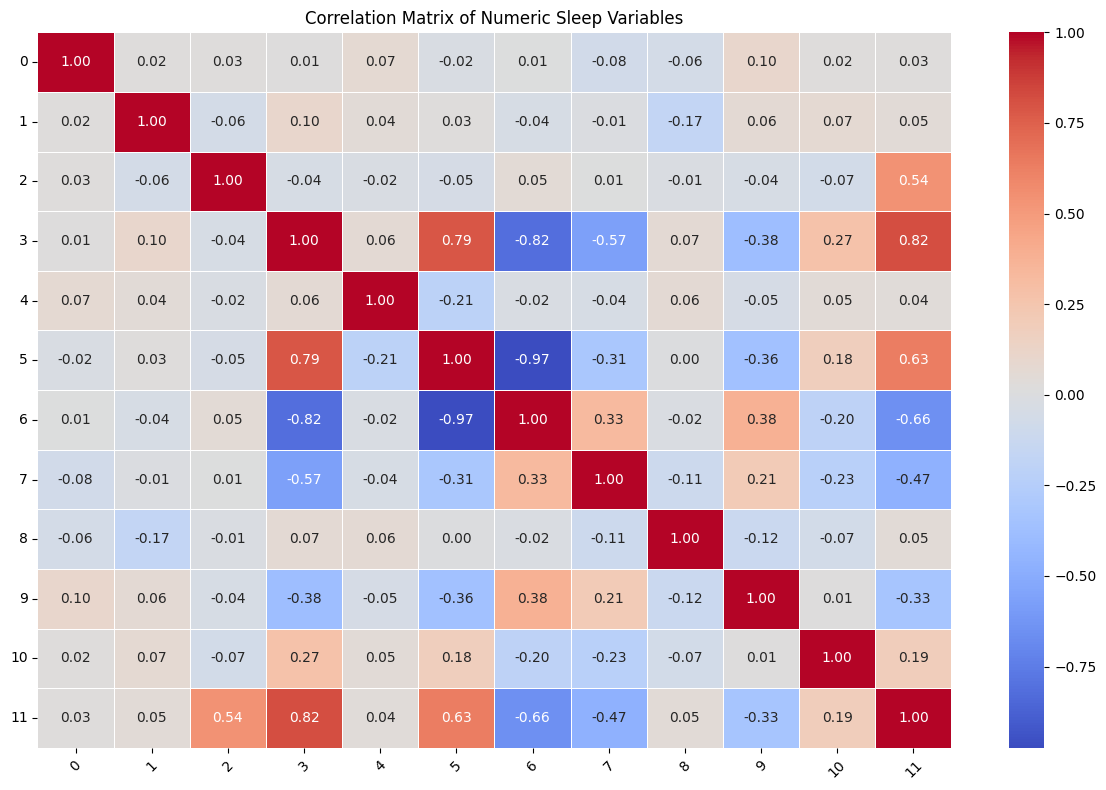

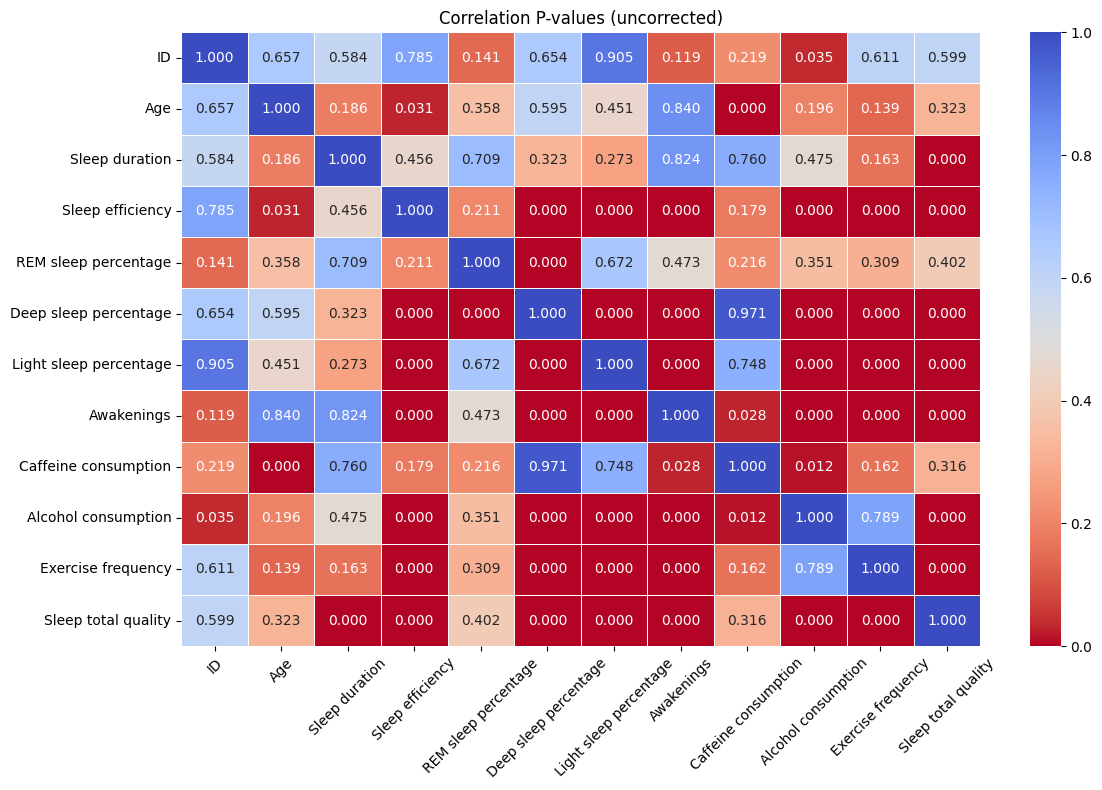

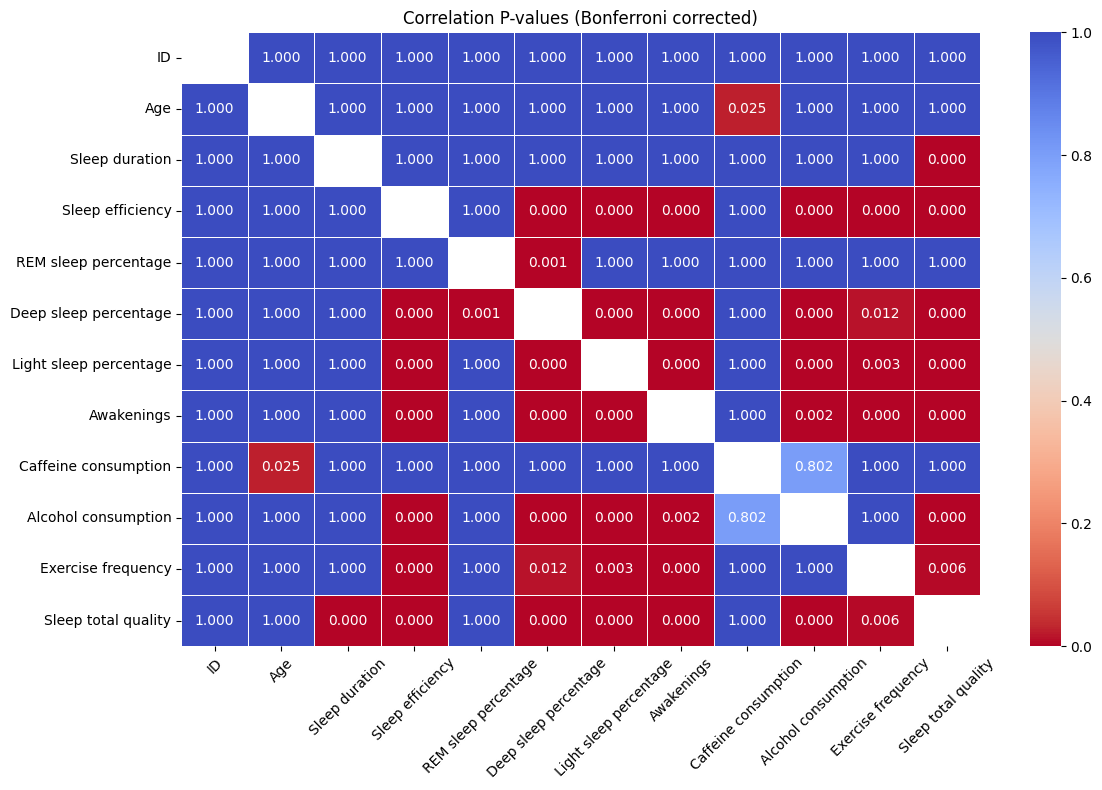

In [55]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Sleep Variables")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
sns.heatmap(pvals, annot=True, cmap='coolwarm_r', fmt=".3f", linewidths=0.5)
plt.title("Correlation P-values (uncorrected)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
sns.heatmap(pvals_corrected_matrix, annot=True, cmap='coolwarm_r', fmt=".3f", linewidths=0.5)
plt.title("Correlation P-values (Bonferroni corrected)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# normality checks:

## 1. histograms:

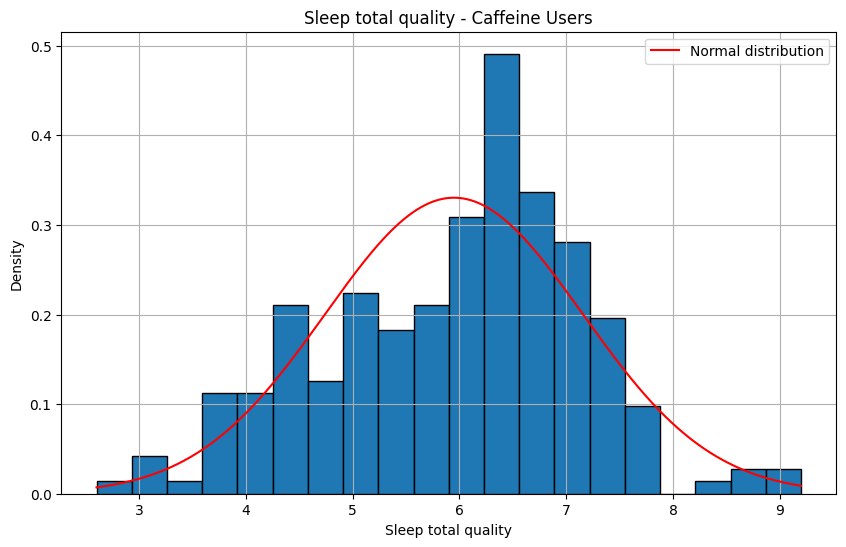

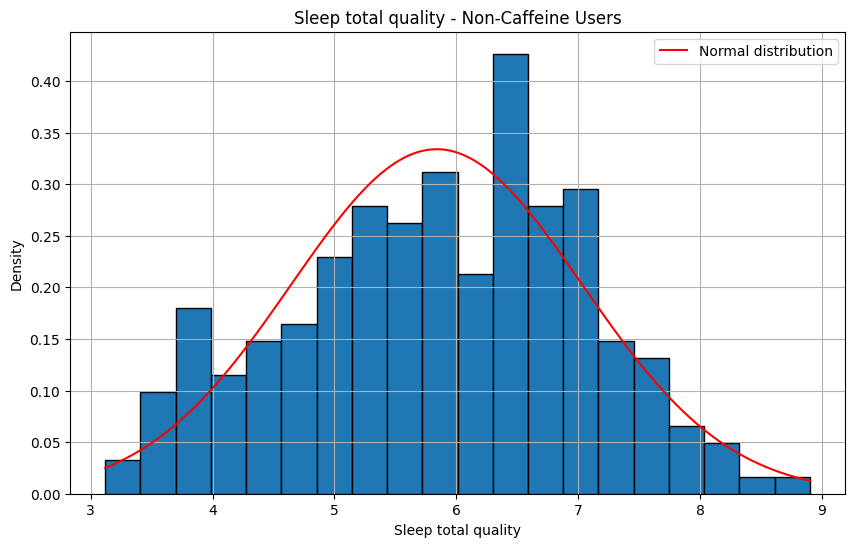

In [56]:
def plot_histogram_with_normal(dataframe, title):
    data = dataframe['Sleep total quality'].dropna()
    mu = data.mean()
    sigma = data.std()

    plt.figure(figsize=(10, 6))
    count, bins_hist, ignored = plt.hist(data, bins=20, density=True, edgecolor='black')

    x = np.linspace(min(data), max(data), 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label='Normal distribution')

    plt.title(title)
    plt.xlabel('Sleep total quality')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram_with_normal(caffeine_users, title='Sleep total quality - Caffeine Users')
plot_histogram_with_normal(non_caffeine_users, title='Sleep total quality - Non-Caffeine Users')


## 2. QQ Plot:

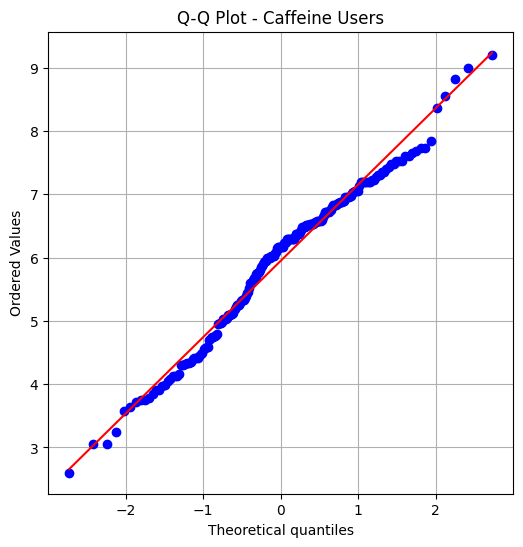

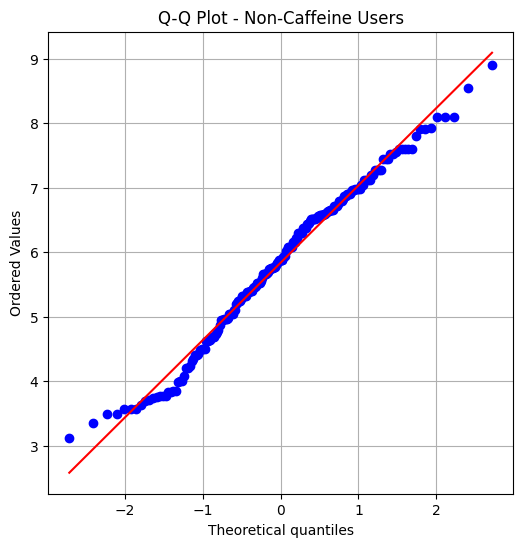

In [57]:
def plot_qq(dataframe, title):
    plt.figure(figsize=(6, 6))
    stats.probplot(dataframe['Sleep total quality'].dropna(), plot=plt)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_qq(caffeine_users, title='Q-Q Plot - Caffeine Users')
plot_qq(non_caffeine_users, title='Q-Q Plot - Non-Caffeine Users')


## 3. Shapiro-Wilk Test:

In [58]:
from scipy.stats import shapiro

def test_normality_shapiro(dataframe, header):
    data = dataframe['Sleep total quality'].dropna()
    stat, p = shapiro(data)
    print(f"\nShapiro-Wilk Test for {header}:")
    print(f"  p-value   = {p:.5f}")

    if p > 0.05:
        print("  -> likely normal")
    else:
        print("  -> not normal")
        
test_normality_shapiro(caffeine_users, 'Caffeine Users' )
test_normality_shapiro(non_caffeine_users, 'Non-Caffeine Users')



Shapiro-Wilk Test for Caffeine Users:
  p-value   = 0.00690
  -> not normal

Shapiro-Wilk Test for Non-Caffeine Users:
  p-value   = 0.02915
  -> not normal


## 4. KS test:

In [59]:
from scipy.stats import kstest
import numpy as np

def test_normality_ks(dataframe, header):
    data = dataframe['Sleep total quality'].dropna()
    standardized_data = (data - np.mean(data)) / np.std(data)

    stat, p = kstest(standardized_data, 'norm')
    print(f"\nKS Test for {header}:")
    print(f"  Statistic = {stat:.4f}")
    print(f"  P-value   = {p:.5f}")

    if p > 0.05:
        print("  -> likely normal")
    else:
        print("  -> not normal")

test_normality_ks(caffeine_users, 'Caffeine Users')
test_normality_ks(non_caffeine_users, 'Non-Caffeine Users')


KS Test for Caffeine Users:
  Statistic = 0.0911
  P-value   = 0.05203
  -> likely normal

KS Test for Non-Caffeine Users:
  Statistic = 0.0639
  P-value   = 0.34013
  -> likely normal


## 4. Anderson-Darling test:

In [60]:
from scipy.stats import anderson

def test_normality_anderson(dataframe, header):
    data = dataframe['Sleep total quality'].dropna()
    result = anderson(data, dist='norm')

    print(f"\nAnderson-Darling Test for {header}:")
    print(f"  Statistic = {result.statistic:.4f}")

    for i in range(len(result.critical_values)):
        sl = result.significance_level[i]
        cv = result.critical_values[i]
        conclusion = "V likely normal" if result.statistic < cv else "X not normal"
        print(f"  Significance level: {sl:.1f}% | Critical value: {cv:.3f} → {conclusion} at this level")

test_normality_anderson(caffeine_users, 'caffeine Users')
test_normality_anderson(non_caffeine_users, 'non-Caffeine Users')


Anderson-Darling Test for caffeine Users:
  Statistic = 1.7221
  Significance level: 15.0% | Critical value: 0.566 → X not normal at this level
  Significance level: 10.0% | Critical value: 0.644 → X not normal at this level
  Significance level: 5.0% | Critical value: 0.773 → X not normal at this level
  Significance level: 2.5% | Critical value: 0.902 → X not normal at this level
  Significance level: 1.0% | Critical value: 1.073 → X not normal at this level

Anderson-Darling Test for non-Caffeine Users:
  Statistic = 0.8608
  Significance level: 15.0% | Critical value: 0.566 → X not normal at this level
  Significance level: 10.0% | Critical value: 0.644 → X not normal at this level
  Significance level: 5.0% | Critical value: 0.773 → X not normal at this level
  Significance level: 2.5% | Critical value: 0.901 → V likely normal at this level
  Significance level: 1.0% | Critical value: 1.072 → V likely normal at this level


# confidence interval:

In [61]:
from scipy.stats import t

mean_diff = caffeine_users['Sleep total quality'].mean() - non_caffeine_users['Sleep total quality'].mean()

se1 = caffeine_users['Sleep total quality'].std(ddof=1) / np.sqrt(caffeine_users.shape[0])
se2 = non_caffeine_users['Sleep total quality'].std(ddof=1) / np.sqrt(non_caffeine_users.shape[0])

df_combined = caffeine_users.shape[0] + non_caffeine_users.shape[0] - 2

se_diff = np.sqrt(se1**2 + se2**2)

confidence_levels = [0.95, 0.90, 0.80, 0.7]
ci_results = {}

for conf in confidence_levels:
    alpha = 1 - conf
    t_crit = t.ppf(1 - alpha / 2, df=df_combined)
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff
    ci_results[conf] = (ci_lower, ci_upper)

print(f"Calculated difference in means: {mean_diff:.3f}")
for conf, (lower, upper) in ci_results.items():
    print(f"{int(conf*100)}% CI for difference in means: ({lower:.2f}, {upper:.2f})")



Calculated difference in means: 0.109
95% CI for difference in means: (-0.12, 0.34)
90% CI for difference in means: (-0.08, 0.30)
80% CI for difference in means: (-0.04, 0.26)
70% CI for difference in means: (-0.01, 0.23)


# hypothesis tests:

## T test:

In [62]:
from scipy.stats import ttest_ind
from scipy.stats import levene

levene_test = levene(
    caffeine_users["Sleep total quality"],
    non_caffeine_users["Sleep total quality"]
)
t_stat, p_value = ttest_ind(
    caffeine_users["Sleep total quality"],
    non_caffeine_users["Sleep total quality"],
    equal_var=(levene_test.pvalue > 0.05)
)

print(levene_test.pvalue > 0.05)
print("T-test statistic:", t_stat)
print("p-value:", p_value)


True
T-test statistic: 0.9415257507116149
p-value: 0.34697035164372436


## Wilcoxon's Test:

In [63]:
u_stat, p_val = mannwhitneyu(
    caffeine_users['Sleep total quality'],
    non_caffeine_users['Sleep total quality'],
    alternative='two-sided'
)

print(f"Mann–Whitney U test statistic: {u_stat}")
print(f"p-value: {p_val}")

Mann–Whitney U test statistic: 24059.0
p-value: 0.31898028962885905


# Regression:

In [64]:
import statsmodels.api as sm

df_filtered = df.dropna(subset=['Caffeine consumption', 'Sleep total quality'])

X = sm.add_constant(df_filtered['Caffeine consumption'])
y = df_filtered['Sleep total quality']

model = sm.OLS(y, X).fit()

print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     Sleep total quality   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     1.007
Date:                 Mon, 11 Aug 2025   Prob (F-statistic):              0.316
Time:                         22:32:32   Log-Likelihood:                -683.18
No. Observations:                  427   AIC:                             1370.
Df Residuals:                      425   BIC:                             1378.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

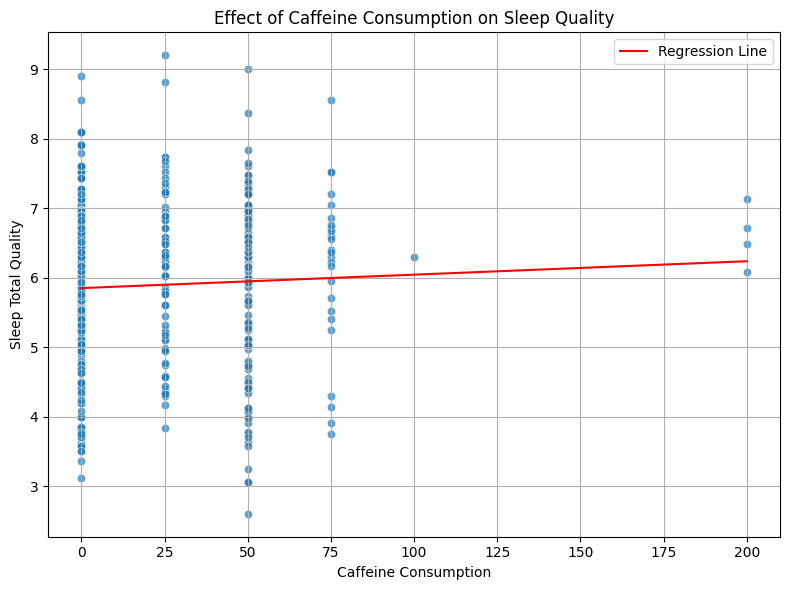

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Caffeine consumption',
    y='Sleep total quality',
    data=df_filtered,
    alpha=0.7
)

x_vals = np.linspace(df_filtered['Caffeine consumption'].min(), df_filtered['Caffeine consumption'].max(), 100)
y_vals = model.params[0] + model.params[1] * x_vals
plt.plot(x_vals, y_vals, color='red', label='Regression Line')

plt.xlabel('Caffeine Consumption')
plt.ylabel('Sleep Total Quality')
plt.title('Effect of Caffeine Consumption on Sleep Quality')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


# Alcohol mix:

In [66]:
def label_group(row):
    caffeine = row['Caffeine consumption'] > 0
    alcohol = row['Alcohol consumption'] > 0
    if not caffeine and not alcohol:
        return 'No Caffeine or Alcohol'
    elif caffeine and not alcohol:
        return 'Caffeine Only'
    elif not caffeine and alcohol:
        return 'Alcohol Only'
    else:
        return 'Caffeine and Alcohol'

df['Group'] = df.apply(label_group, axis=1)


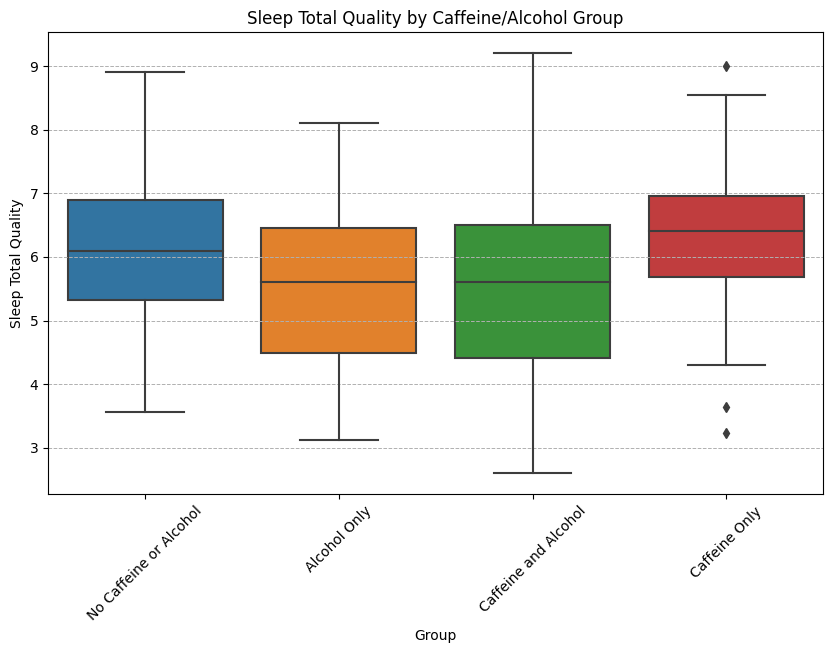

In [67]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Group', y='Sleep total quality', data=df)
plt.grid(True, axis='y', linestyle='--', linewidth=0.7) 
plt.xticks(rotation=45)
plt.title('Sleep Total Quality by Caffeine/Alcohol Group')
plt.ylabel('Sleep Total Quality')
plt.show()


In [68]:
from scipy.stats import f_oneway

grouped = df.groupby('Group')['Sleep total quality'].apply(list)

anova_result = f_oneway(*grouped)

print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"p-value: {anova_result.pvalue:.10f}")


F-statistic: 11.861
p-value: 0.0000001792


In [69]:
groups = df['Group'].unique()
pairs = list(itertools.combinations(groups, 2))
results = []

for g1, g2 in pairs:
    data1 = df.loc[df['Group'] == g1, 'Sleep total quality']
    data2 = df.loc[df['Group'] == g2, 'Sleep total quality']
    
    stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')
    
    results.append({'Group 1': g1, 'Group 2': g2, 'p-value': pval})

results_df = pd.DataFrame(results)
m = len(results_df)
results_df['p-value corrected'] = results_df['p-value'] * m
results_df['p-value corrected'] = results_df['p-value corrected'].clip(upper=1)
print(results_df)



                  Group 1               Group 2   p-value  p-value corrected
0  No Caffeine or Alcohol          Alcohol Only  0.001264           0.007587
1  No Caffeine or Alcohol  Caffeine and Alcohol  0.001486           0.008914
2  No Caffeine or Alcohol         Caffeine Only  0.098286           0.589718
3            Alcohol Only  Caffeine and Alcohol  0.872061           1.000000
4            Alcohol Only         Caffeine Only  0.000005           0.000032
5    Caffeine and Alcohol         Caffeine Only  0.000005           0.000032
